<a href="https://colab.research.google.com/github/devangi2000/Deep-Learning/blob/master/Tutorial_05_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from IPython.display import HTML, display


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)


def show_scatterplot(X, colors, title=''):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=30)
    # plt.grid(True)
    plt.title(title)
    plt.axis('off')


def plot_bases(bases, width=0.04):
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    plt.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    plt.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)


def show_mat(mat, vect, prod, threshold=-1):
    # Subplot grid definition
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=True,
                                        gridspec_kw={'width_ratios':[5,1,1]})
    # Plot matrices
    cax1 = ax1.matshow(mat.numpy(), clim=(-1, 1))
    ax2.matshow(vect.numpy(), clim=(-1, 1))
    cax3 = ax3.matshow(prod.numpy(), clim=(threshold, 1))

    # Set titles
    ax1.set_title(f'A: {mat.size(0)} \u00D7 {mat.size(1)}')
    ax2.set_title(f'a^(i): {vect.numel()}')
    ax3.set_title(f'p: {prod.numel()}')

    # Remove xticks for vectors
    ax2.set_xticks(tuple())
    ax3.set_xticks(tuple())
    
    # Plot colourbars
    fig.colorbar(cax1, ax=ax2)
    fig.colorbar(cax3, ax=ax3)

    # Fix y-axis limits
    ax1.set_ylim(bottom=max(len(prod), len(vect)) - 0.5)


colors = dict(
    aqua='#8dd3c7',
    yellow='#ffffb3',
    lavender='#bebada',
    red='#fb8072',
    blue='#80b1d3',
    orange='#fdb462',
    green='#b3de69',
    pink='#fccde5',
    grey='#d9d9d9',
    violet='#bc80bd',
    unk1='#ccebc5',
    unk2='#ffed6f',
)


def _cstr(s, color='black'):
    if s == ' ':
        return f'<text style=color:#000;padding-left:10px;background-color:{color}> </text>'
    else:
        return f'<text style=color:#000;background-color:{color}>{s} </text>'

# print html
def _print_color(t):
    display(HTML(''.join([_cstr(ti, color=ci) for ti, ci in t])))

# get appropriate color for value
def _get_clr(value):
    colors = ('#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
              '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
              '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
              '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e')
    value = int((value * 100) / 5)
    if value == len(colors): value -= 1  # fixing bugs...
    return colors[value]

def _visualise_values(output_values, result_list):
    text_colours = []
    for i in range(len(output_values)):
        text = (result_list[i], _get_clr(output_values[i]))
        text_colours.append(text)
    _print_color(text_colours)

def print_colourbar():
    color_range = torch.linspace(-2.5, 2.5, 20)
    to_print = [(f'{x:.2f}', _get_clr((x+2.5)/5)) for x in color_range]
    _print_color(to_print)


# Let's only focus on the last time step for now
# First, the cell state (Long term memory)
def plot_state(data, state, b, decoder):
    actual_data = decoder(data[b, :, :].numpy())
    seq_len = len(actual_data)
    seq_len_w_pad = len(state)
    for s in range(state.size(2)):
        states = torch.sigmoid(state[:, b, s])
        _visualise_values(states[seq_len_w_pad - seq_len:], list(actual_data))


In [2]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from matplotlib import pyplot as plt

In [3]:
set_default()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
seed = 1
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 1  # dimensions
C = 1  # num_classes
H = 100  # num_hidden_units

In [7]:
 X = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1).to(device)
 y = X.pow(3) + 0.3 * (torch.rand(X.size()).to(device))

In [9]:
print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (100, 1)
y: (100, 1)


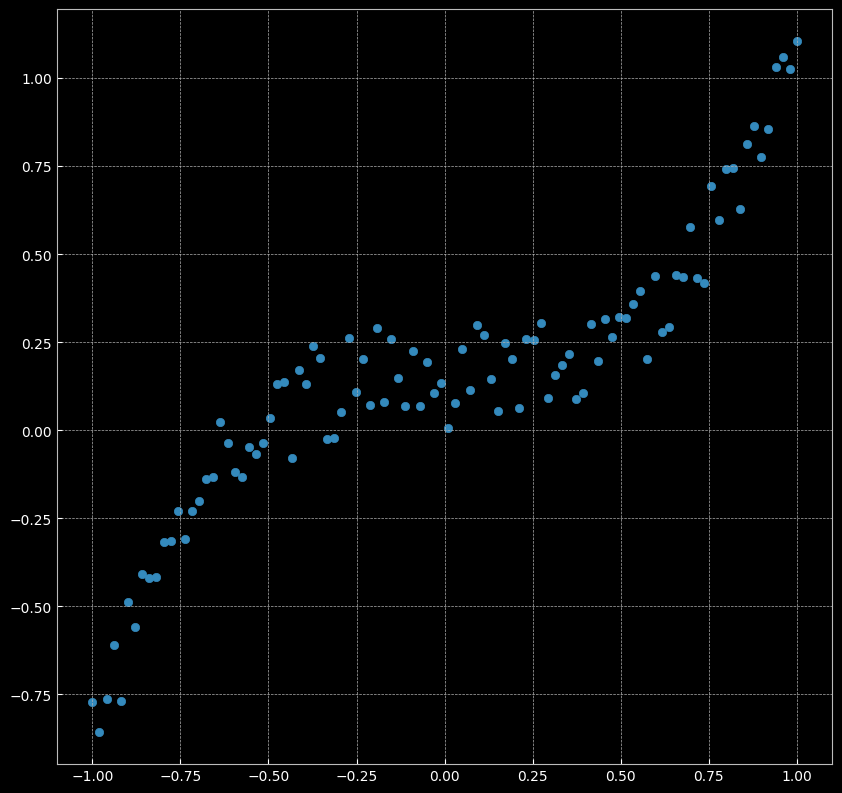

In [10]:
plt.scatter(X.cpu().numpy(), y.cpu().numpy())
plt.axis('equal');

## Linear model

In [11]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [12]:
# nn package to create our linear model
# each Linear module has a weight and bias
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device) # Convert to CUDA

# nn package also has different loss functions.
# we use MSE loss for our regression task
criterion = torch.nn.MSELoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss (MSE)
    loss = criterion(y_pred, y)
    print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (t, loss.item()))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS or MSE]: 0.029701


In [13]:
# Plot trained model
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=1, bias=True)
)


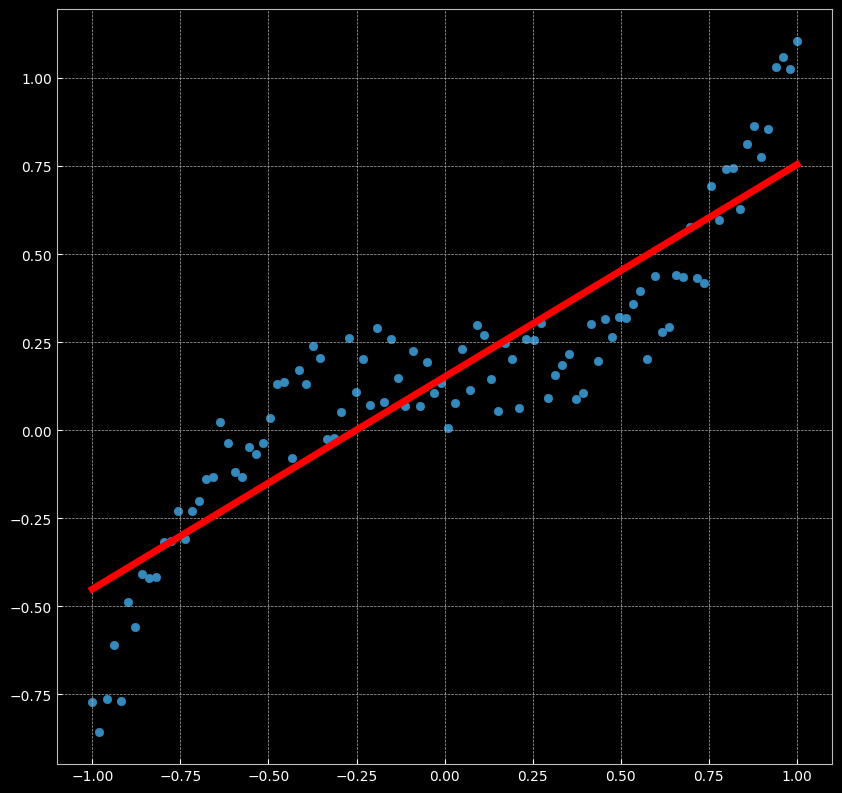

In [16]:
plt.scatter(X.data.cpu().numpy(), y.data.cpu().numpy())
plt.plot(X.data.cpu().numpy(), y_pred.data.cpu().numpy(), 'r-', lw=5)
plt.axis('equal');

## Two-layered Network

In [17]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [19]:
# Number of networks
n_networks = 10
models = list()
y_pretrain = list()

# nn package also has different loss functions.
# we use MSE for a regression task
criterion = torch.nn.MSELoss()

for mod in range(n_networks):
    # nn package to create our linear model
    # each Linear module has a weight and bias
    model = nn.Sequential(
        nn.Linear(D, H),
        nn.ReLU() if mod < n_networks // 2 else nn.Tanh(),
        nn.Linear(H, C)
    )
    model.to(device)

    # Append models
    models.append(model)

    # we use the optim package to apply
    # ADAM for our parameter updates
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

    # e = 1.  # plotting purpose

    # Training
    for t in range(1000):
        # feed forward to get the logits
        y_pred = model(X)

        # append pre-train output
        if t == 0:
            y_pretrain.append(y_pred.detach())

        # Compute loss and accuracy
        loss = criterion(y_pred, y)
        print(f'[MODEL]: {mod+1}, [EPOCH]: {t}, [LOSS]: {loss.item():.6f}')
        display.clear_output(wait=True)

        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()

        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()

        # Update params
        optimizer.step()

[MODEL]: 10, [EPOCH]: 999, [LOSS]: 0.007534


In [20]:
print(models[0], models[-1])

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
) Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=1, bias=True)
)


In [21]:
print(models)

[Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
), Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
), Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
), Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
), Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
), Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=1, bias=True)
), Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=1

## Predictions: Before Training

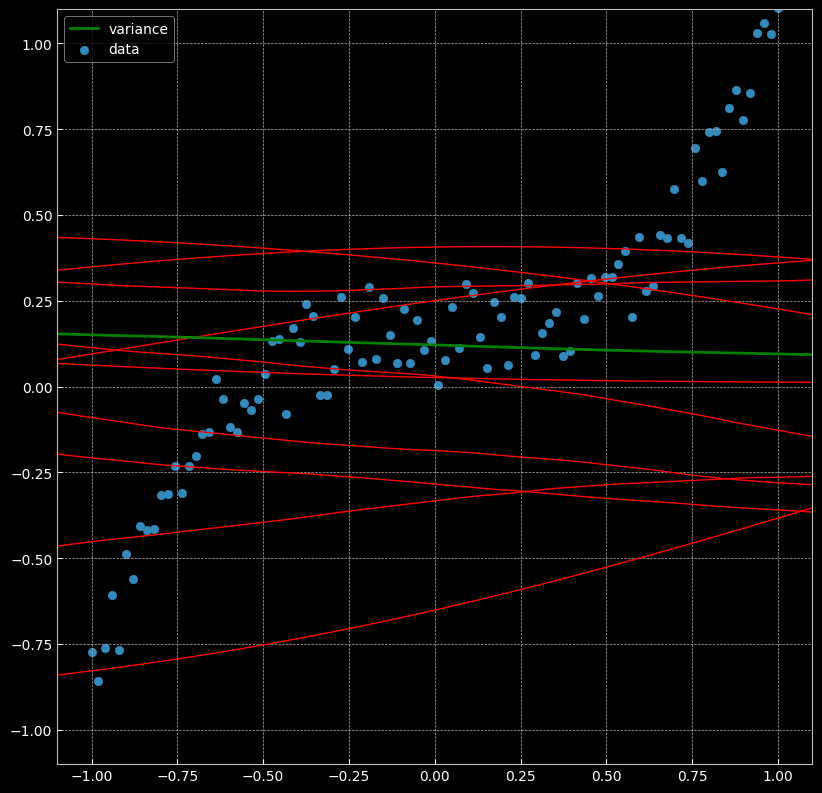

In [22]:
for y_pretrain_idx in y_pretrain:
    # New X that ranges from -5 to 5 instead of -1 to 1
    X_new  = torch.unsqueeze(torch.linspace(-2,2,100), dim=1)

    plt.plot(X_new.numpy(), y_pretrain_idx.cpu().numpy(), 'r-', lw=1)

plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='data')
plt.axis('square')
plt.axis((-1.1, 1.1, -1.1, 1.1));
y_combo = torch.stack(y_pretrain)
plt.plot(X_new.numpy(), y_combo.var(dim=0).cpu().numpy(), 'g', label='variance');
plt.legend()

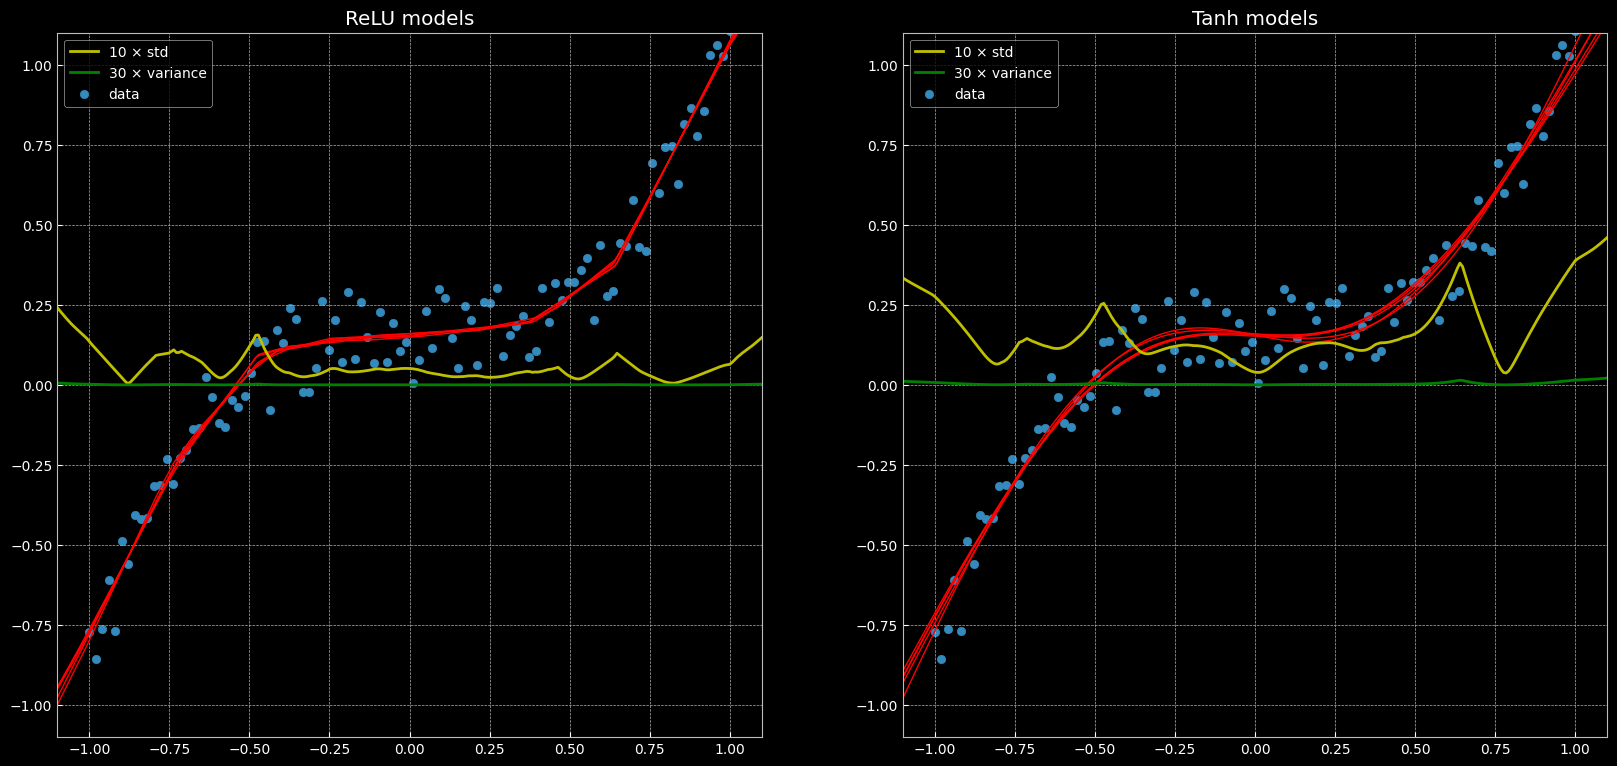

In [23]:
y_pred = list()
relu_models = models[:n_networks // 2]
tanh_models = models[n_networks // 2:]
plt.figure(figsize=(20, 10))

def dense_prediction(models, non_linearity, zoom):
    plt.subplot(1, 2, 1 if non_linearity == 'ReLU' else 2)
    for model in models:
        # New X that ranges from -5 to 5 instead of -1 to 1
        X_new = torch.unsqueeze(torch.linspace(-4, 4, 1001), dim=1).to(device)

        # Getting predictions from input
        with torch.no_grad():
            y_pred.append(model(X_new))

        plt.plot(X_new.cpu().numpy(), y_pred[-1].cpu().numpy(), 'r-', lw=1)
    plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='data')
    plt.axis('square')
    plt.axis(torch.tensor((-1.1, 1.1, -1.1, 1.1)) * zoom);
    y_combo = torch.stack(y_pred)
    plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().sqrt().numpy(), 'y', label='10 × std')
    plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().numpy(), 'g', label='30 × variance')
    plt.legend()
    plt.title(non_linearity + ' models')

z = 1  # try 1 or 4
dense_prediction(relu_models, 'ReLU', zoom=z)
dense_prediction(tanh_models, 'Tanh', zoom=z)